# Problem 9.1

**Integrated Energy Grids**

**Problem 9.2. Join capacity and dispatch optimization with storage and CO2 emissions limits.**

**Use the model built in PyPSA described in Problem 8.2 and assume that methane gas emits 0.198 tCO2 per MWh of thermal energy contained in the gas. Limit the maximum CO2 emissions to 5 MtCO2/year.**

**a) Calculate the optimal installed capacities and plot the hourly generation and demand during January.**

**b) What is the CO2 tax required to attain such CO2 emissions limit?**


:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

:::{note}
See also https://model.energy.
:::

In this exercise, we want to build a replica of [model.energy](https://model.energy). This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world. We deviate from [model.energy](https://model.energy) by including electricity demand profiles rather than a constant electricity demand. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

Set parameter Username
Set parameter LicenseID to value 2767832
Academic license - for non-commercial use only - expires 2027-01-20


## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

Now we can for example read the capital and marginal cost of onshore wind and solar, or the emissions factors of the carrier gas used in and OCGT

In [9]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

np.float64(101644.12332388277)

In [10]:
costs.at["solar", "capital_cost"] #EUR/MW/a

np.float64(51346.82981964593)

In [11]:
costs.at["CCGT", "CO2 intensity"] #tCO2/MWh_th

np.float64(0.198)

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [12]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [13]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal in this excercise

In [14]:
country = 'PRT'

### Join capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity bus.

In [15]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus",
      "electricity")

n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

We add all the technologies we are going to include as carriers. 

In [16]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "CCGT",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred","yellow-green", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Next, we add the demand time series to the model.

In [17]:
# add load to the bus
n.add("Load",
      "demand",
      bus="electricity",
      p_set=data_el[country].values)

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

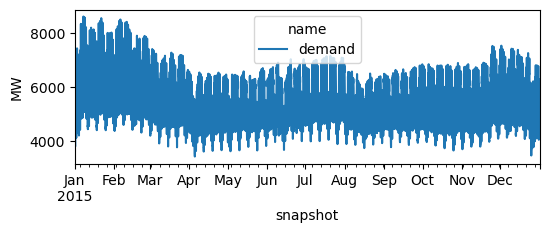

In [18]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [19]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

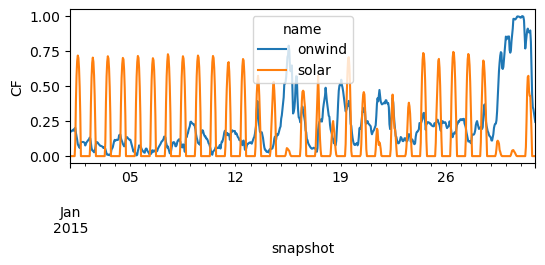

In [20]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the battery storage, assuming a fixed energy-to-power ratio of 2 hours, i.e. if fully charged, the battery can discharge at full capacity for 2 hours. 

For the capital cost, we have to factor in both the capacity and energy cost of the storage. 

We include the charging and discharging efficiencies we enforce a cyclic state-of-charge condition, i.e. the state of charge at the beginning of the optimisation period must equal the final state of charge.

In [21]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

We add the Combined Cycle Gas Turbine (CCGT). In this case, its capacity is not extendable but fixed to 1 GW. 

In [22]:
n.add(
    "Generator",
    "CCGT",
    bus="electricity",
    carrier="CCGT",
    capital_cost=costs.at["CCGT", "capital_cost"],
    marginal_cost=costs.at["CCGT", "marginal_cost"],
    efficiency=costs.at["CCGT", "efficiency"],
    p_nom=6000, #6 Gw
)

### Model Run

Before solving the problem we add a CO$_2$ emission limit as global constraint:

In [23]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=5000000, #5MtCO2
)

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [24]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 155.21it/s]
INFO:linopy.io: Writing time: 2.47s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-r_t95njn has 140165 rows; 61324 cols; 275962 nonzeros
Coefficient ranges:
  Matrix  [1e-03, 2e+00]
  Cost    [1e-02, 1e+05]
  Bound   [0e+00, 0e+00]
  RHS     [3e+03, 5e+06]
Presolving model
65719 rows, 56962 cols, 197154 nonzeros  0s
Dependent equations search running on 17520 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
65719 rows, 56962 cols, 197154 nonzeros  0s
Presolve reductions: rows 65719(-74446); columns 56962(-4362); nonzeros 197154(-78808) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.89297e+07) 1s
      15906     9.1940602692e+08 Pr: 15371(6.49639e+07) 6s
      32829     2.1299466599e+09 Pr: 25683(1.51646e+08); Du: 0(7.17811e-09) 11s
      34209     2.3806790908e+09 Pr: 28850

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61324 primals, 140165 duals
Objective: 2.76e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.



Model name          : linopy-problem-r_t95njn
Model status        : Optimal
Simplex   iterations: 47873
Objective value     :  2.7611963275e+09
P-D objective error :  9.0663422053e-15
HiGHS run time      :         49.30


('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year)

In [25]:
n.objective / 1e9

2.761196327509703

The optimised capacities in GW:

In [26]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

name
OCGT      -0.000000
onwind    12.548370
solar     10.281573
CCGT       6.000000
Name: p_nom_opt, dtype: float64

In [27]:
n.storage_units.p_nom_opt.div(1e3)  # MW -> GW

name
battery storage    4.830266
Name: p_nom_opt, dtype: float64

The total energy generation by technology in TWh:

In [28]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

name
OCGT       0.000000
onwind    19.021846
solar     15.491719
CCGT      14.646465
dtype: float64

We can plot the dispatch of every generator thoughout January

<Axes: xlabel='snapshot', ylabel='dispatch'>

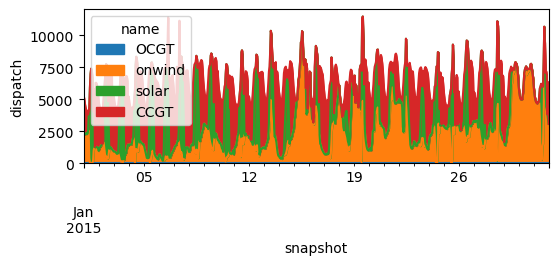

In [29]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

We can also plot the charging and discharging of the battery

<Axes: xlabel='snapshot', ylabel='battery'>

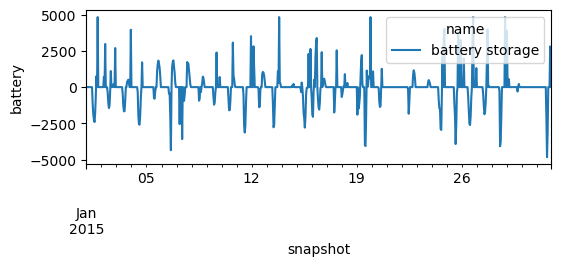

In [30]:
n.storage_units_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="battery")

**b) What is the CO2 tax required to attain such CO2 emissions limit?**

We can read the Lagrange/KKT multiplier associated to the maximum CO2 limit constraint

In [31]:
n.global_constraints

,type,investment_period,bus,carrier_attribute,sense,constant,mu
name,,,,,,,
CO2Limit,primary_energy,NaN,,co2_emissions,<=,5000000.0,-190.502335


In this case, we get a negative multiplier indicating that when the constant in the constraint equation (allowed CO2 emisssions) increases, the objective function (total system costs) decreases. 